Force experienced by a magnetic bead in an external non-homogenous B. Here, we focus on 2D problem since microscope FoV limits observations to 2D projections.

$
\begin{align}
F_{bead} &= V \cdot M(B) \cdot \nabla B(x,y)
\end{align}
$

M - Magnetization of the bead (A/m), V - volume of the bead ($m^3$), and $\nabla$ B - magnetic field gradient. 

B depends on directly on i linearly or non-linearly depending on the core properties. Constant core permeability gives linear dependence between B and i$_input$ whereas B-H based core permeability suggests non-linear dependence which saturates at certain input current levels.

B is simulated using Comsol and Gaussian current loop technique. From Comsol: \textbf{B}(x,y,i = 0.5 A) and direction angle $\alpha$. From this $\nabla B_x$ and $\nabla B_y$ were derived and sampled based on {x,y} coordinates in the calculations. The spatial density of the simulation was 0.05mm ( $\partial x = \partial y = 5 \cdot 10^{-5}$)

$
\begin{align}
B_x &= B \cos( \alpha ) \\
B_y &= B \sin( \alpha ) \\
\nabla B &= [\frac{ \partial |B|}{\partial x}, \frac{ \partial |B|}{\partial y} ]
\end{align}
$

M(B) can be derived from magnetization measurements which give magnetic moment ($m$) as a function of magnetic field intensity ($H$). Here, we calculate both mass and volumetric magnetization. Mass magnetization is used to compare with tds and volumetric in calculations.

$
\begin{align}
M_{\text{mass}} &= \frac{m}{mass} \\
M_{\text{volumetric}} &= \frac{m}{V}
\end{align}
$

A displacement model for a magnetic bead was used to simulate the bead dispalcement in the field. Both x and y coordinates were managed independently.

k - number of timestep
dt - length of timestep
$\rho$ - density
s$_{k, \text{bead}}$ - bead position
v$_{k, \text{bead}}$ - bead velocity
a$_{k, \text{bead}}$ - bead acceleration

$
\begin{align}
f_{\text{bead}} &= mass \cdot a \rightarrow a = \frac{f_{\text{bead}}}{mass} = \frac{f_{\text{bead}}}{\rho \cdot V_{\text{bead}}} \\
s_{k, \text{bead}}  &= s_{k-1, \text{bead}} + v_{k-1, \text{bead}}*dt + \frac{f}{m}*dt^2 \\
v_{k, \text{bead}} &= v_{k-1, \text{bead}} + \frac{f}{m}*dt \\
\end{align}
$


Mechanocal pareameters were derived from simulated and experimental displacement data using 1) classical micromechnical models 1.0) without B adjustment and 1.1) with B adjustment. Without B adjustment moving bead do not experience constant magnetic gradient since nonhomogenous B. Here, assumptions of constant force in previous studies are evaluated.

Creep:

kelvin-Voigt model and burger model:

$
\begin{align}
\epsilon_{\text{Kelvin-Voigt}} (t) &= \frac{1}{E}*(1-e^{\frac{-E t}{n}}) \\
\epsilon_{\text{Burger's}} (t) &= \sigma \left( \frac{1}{E_1} + \frac{t}{n_1} + \frac{1}{E_2} (1 - e^{ \frac{-E_2 t}{n_2}}) \right)
\end{align}
$

Relaxation:

maxwell model and burger model:

$
\begin{align}
\epsilon_{\text{Kelvin-Voigt}} (t) &= E e^{ \frac{- E t}{n}} \\
\epsilon_{\text{Burger's}} (t) &= 
\end{align}
$

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os 

import _pickle as cPickle
from glob import glob

import json

import scipy
from scipy.optimize import curve_fit

import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


In [363]:
#Configs

root = "F:/demoData"

ni_rate = 100
camera_rate = 40
rate_rate = ni_rate/camera_rate

m = 3.5/(10*0.3*2.6)

start = int(500/rate_rate)
end = int(1150/rate_rate)

radius = 5.5e-6
rho = 1.3 * 1000 # kg/m^3


In [440]:
def calc_force(data):

    radius = 5.5e-6
    T_0 = 25
    r_T_0 = 0.971e3
    v = 30000e-6
    volume = np.pi*radius**2

    # our experiments
    T = 23
    a = 9.2e-4
    b = 4.5e-7
    r = r_T_0/(1+a*(T-T_0)+b*(T-T_0)**2)
    nn = v*r

    v_fit = np.mean(np.abs(data))
    F_fit = 6*np.pi*nn*radius*v_fit

    return F_fit

def func(x, a, b):
    return a*np.tanh(x*b)

In [441]:
path_multi_track = glob(os.path.join(root,"track_5/*.json"))
with open(path_multi_track[0], "rb") as input_file:
    file_dict = json.load(input_file)

for i in file_dict.keys():
    parts = i.split("_")
    if parts[0] == "ref":
        if parts[1] == "0":
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end][start:end].reset_index()
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_ref = temp_df
            df_ref["label"] = parts[1]
        else:
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["label"] = parts[1]
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_ref = pd.concat((df_ref,temp_df))
        df_ref["type"] = "ref"
        #df_ref["label"] = parts[1]
    else:
        if parts[1] == "0":
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_mg = temp_df
            df_mg["label"] = parts[1]
        else:
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["label"] = parts[1]
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_mg = pd.concat((df_mg,temp_df))
        
        df_mg["type"] = "mg"
            #df_mg["label"] = parts[1]

Text(0.5, 0, 'x-coordinate [um]')

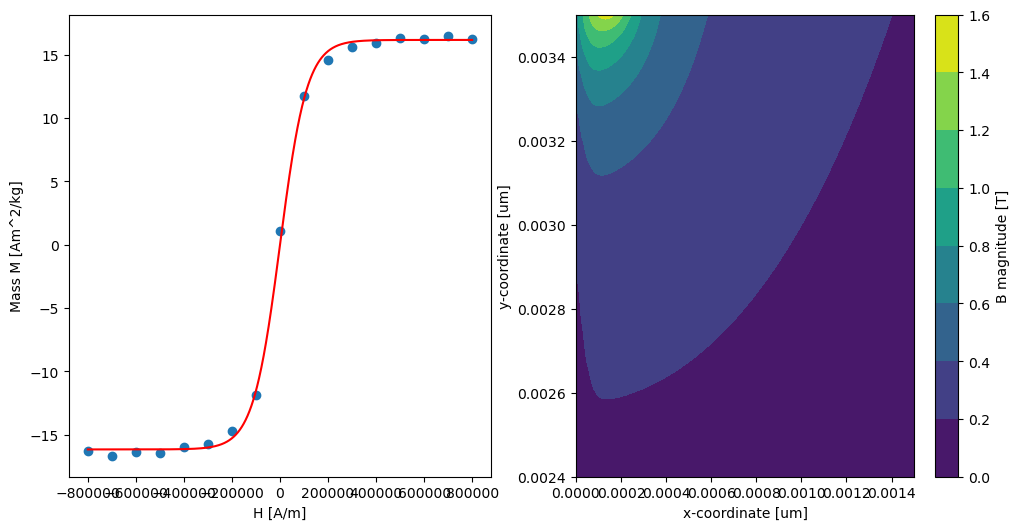

In [444]:
# Units https://www.nist.gov/system/files/documents/pml/electromagnetics/magnetics/magnetic_units.pdf

fig, ax  = plt.subplots(1, 2, figsize = (12,6))

paths = glob("F:/demoData/resource/*.dat")

#These are magnetization values for the beads for micromod data sheet
mgM = np.array([-6.6, -4.3, 0, 4.3, 6.6]) #Mass magnetization
mgH = np.array([-800e3, -80e3, 0, 80e3, 800e3]) #Field intensity

for count,i in enumerate(paths):
    ending = i.split("\\")[1]
    parts = ending.split("_")
    day = parts[0]
    size = float(parts[1][:-7])*1e-6
    weight = float(parts[2][:-6])*1e-8 #*0.0275

    df_sub = pd.read_csv(i, sep= ",", skiprows = np.arange(0,31)).iloc[1:, :].dropna(how='all', axis = "columns")
    df_sub["sample"] = count
    df_sub["size"] = size
    df_sub["weight"] = weight

    #Oe  1/(4pi)*10^3 A/m
    df_sub["H"] = df_sub["Magnetic Field (Oe)"] * 1/(4*np.pi)*1e3
    #= 1 emu 10−3 A·m2
    df_sub["moment"] = df_sub["Moment (emu)"]*1e-3

    start_sat = np.where(df_sub["H"][:125].values>600e3)[0][0]
    end_sat = np.argmax(df_sub["H"][:125].values)

    k = np.polyfit(df_sub["H"][start_sat:end_sat].values,df_sub["moment"][start_sat:end_sat].values-df_sub["moment"][start_sat:end_sat].values[0],deg = 1, cov = False)
    offset = k[0]*df_sub["H"]

    df_sub["moment"] = df_sub["moment"] - offset
    df_sub["M_mass"] = df_sub["moment"]/(weight)

    if count == 0:
        df_bead = df_sub
    else:
        df_bead = pd.concat((df_bead,df_sub))

df_bead["H_round"] = np.round(df_bead["H"].values, -5)
fd_mean = df_bead.groupby(["H_round"]).mean().reset_index()

xdata = np.linspace(-800000,800000,1000)
popt, pcov = curve_fit(func, fd_mean["H_round"], fd_mean["M_mass"], method = "dogbox",  bounds = [[0,1/1000000],[20,1/7000]])
ydata = func(xdata, *popt)

M_mag = ydata*rho
B_mag = xdata*1.257e-6

ax[0].plot(xdata, ydata,color = "red")
ax[0].scatter(fd_mean["H_round"],fd_mean["M_mass"], label = "sample mean")
ax[0].set_xlabel("H [A/m]")
ax[0].set_ylabel("Mass M [Am^2/kg]")

df_sim = pd.read_csv(os.path.join(root, "resource/One_coil.csv"), sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])

df_sim["Bx"] = scipy.ndimage.gaussian_filter1d(df_sim["Bx"].values,5)
df_sim["By"] = scipy.ndimage.gaussian_filter1d(df_sim["By"].values,5)
df_sim["x"] = np.round(df_sim["x"],5)
df_sim["y"] = np.round(df_sim["y"],5)
df_sim["B"] = np.sqrt((df_sim["Bx"].values)**2 +  df_sim["By"].values**2)

map_x = df_sim["x"].unique()
map_y = df_sim["y"].unique()
B = df_sim["B"].values
B = B.reshape((len(map_y), len(map_x)))

h = ax[1].contourf(map_x, map_y, B)
cbar = fig.colorbar(h, label = "B magnitude [T]")

ax[1].set_ylim([0.0024, 0.0035])
ax[1].set_xlim([0.0, 0.0015])

ax[1].set_ylabel("y-coordinate [um]")
ax[1].set_xlabel("x-coordinate [um]")



(0.0, 2000.0)

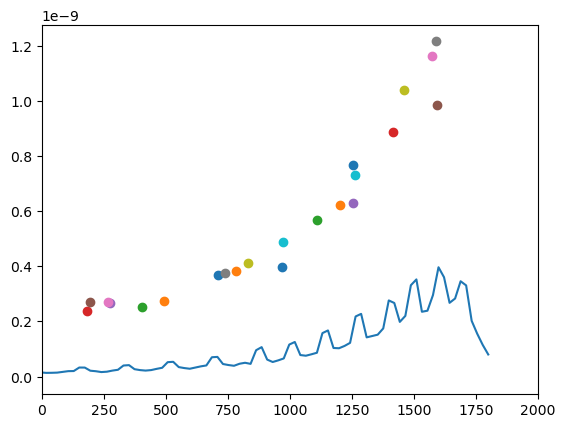

Text(0, 0.5, 'velocity [um/s]')

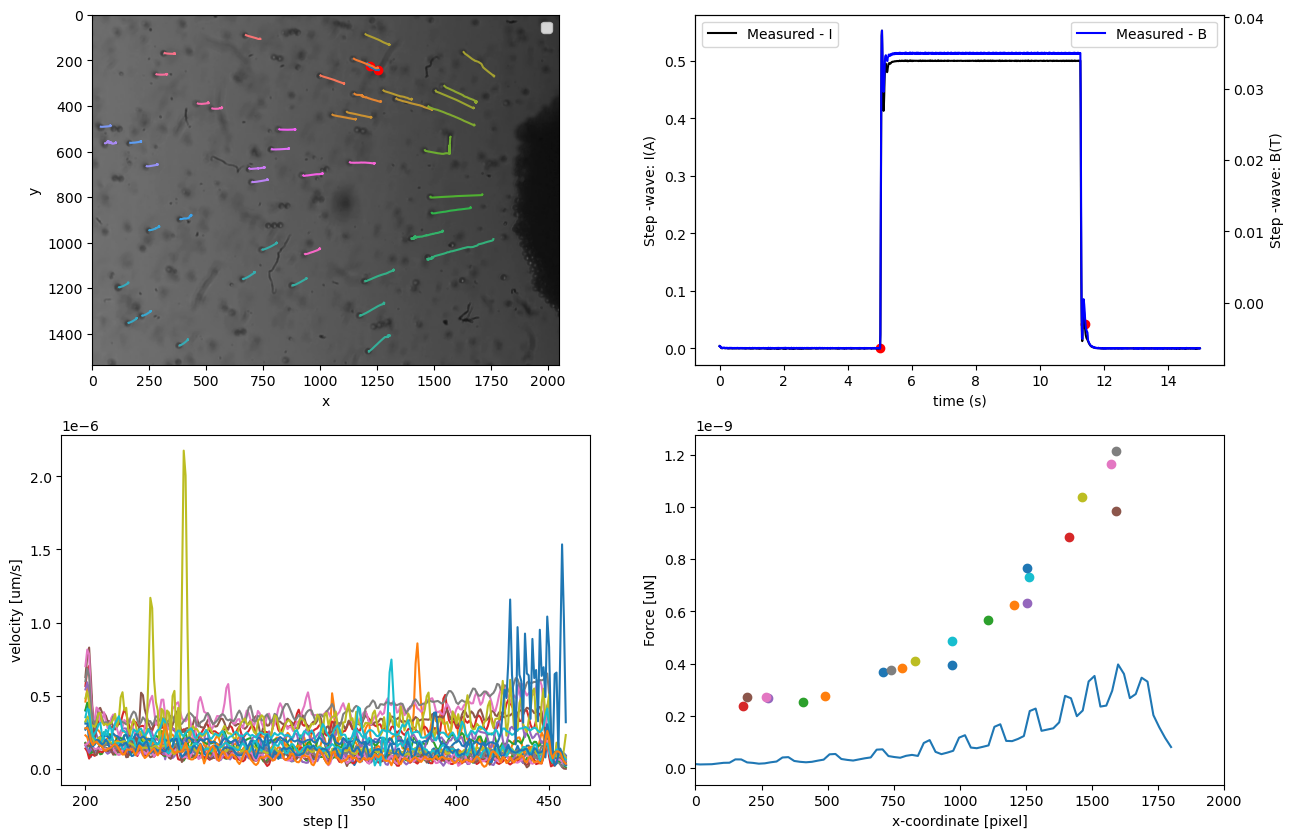

In [448]:
fig, ax  = plt.subplots(2, 2, figsize = (15,10))

path_vid = glob(os.path.join(root,"track_5/*.mp4"))

cap = cv2.VideoCapture(path_vid[0])

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        #frame = cv2.flip(frame,0)
        break

ax[0,0].imshow(frame)

path_track = os.path.join(root,"track_5/trackingData_2024-02-01.pickle")

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)

df_track = pd.DataFrame.from_dict(file_track)

df_track["x_scaled"] = 2250 - df_track["y"]/m 
df_track["y_scaled"] = 1500 - df_track["x"]/m 

ax[0,0].plot(df_track["x_scaled"].values[start:end],df_track["y_scaled"][start:end])
ax[0,0].scatter(df_track["x_scaled"].values[int(500/rate_rate)],df_track["y_scaled"].values[int(500/rate_rate)], color = "red")
ax[0,0].scatter(df_track["x_scaled"].values[int(1150/rate_rate)],df_track["y_scaled"].values[int(1150/rate_rate)], color = "red")

ax[0,1].set_ylabel("y-coordinate [pixel]")
ax[0,1].set_xlabel("x-coordinate [pixel]")

#Load calibration
path = os.path.join(root,"track_5/driver_2024-02-01.npy")
df = pd.DataFrame(np.load(path).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax1 = ax[0,1].twinx()

ax1.plot(df["index"],df["Mg"], color = "blue", label = "Measured - B ")
ax[0,1].plot(df["index"], df["measured"], color = "black", label = "Measured - I")
ax[0,1].scatter(df["index"].values[int(500/1)], df["measured"].values[int(500/1)], color = "red")
ax[0,1].scatter(df["index"].values[int(1140/1)], df["measured"].values[int(1140/1)], color = "red")

ax[0,1].set_ylabel("Step -wave: I(A)")
ax[0,1].set_xlabel("time (s)")
ax[0,1].legend(loc = "upper left")

ax1.set_ylabel("Step -wave: B(T)")
ax1.legend(loc = "upper right")

ax[1,1].set_xlabel("x-coordinate [pixel]")
ax[1,1].set_ylabel("Force [uN]")

sns.lineplot(x = "x", y = "y", data = df_mg, hue = "label", ax = ax[0,0])
ax[0,0].legend([])

idx = df_sim["x"] == 0.01e-03

B_idx = scipy.ndimage.gaussian_filter(df_sim["B"].values[idx],5)
B_grad = np.gradient(df_sim["B"].values[idx])


for i in df_mg["label"].unique()[1::2]:
    
    df_test = df_mg[df_mg["label"] == i]
    df_test["v"] = np.sqrt(np.gradient(df_test["x"]*m*1e-6)**2 + np.gradient(df_test["y"]*m*1e-6)**2)
    ax[1,0].plot(df_test["index"], df_test["v"])

    F = calc_force(df_test["v"].values)

    ax[1,1].scatter(np.mean(df_test["x"]), F)

M_values = np.zeros_like(B_idx)
for count,i in enumerate(B_idx):
    idx_current = np.argmin(np.abs(B_mag-i))
    M_values[count] = M_mag[idx_current]

F_sim = M_values*B_grad*(4/3*np.pi*(5.5e-6)**3)

xAxis = df_sim["y"].values[idx]/(m*1e-6)-6000
ax[1,1].plot(xAxis,F_sim*1e3, label = "dB_x simualtion scaled")
ax[1,1].set_xlim([0,2000])

ax[1,0].set_xlabel("step []")
ax[1,0].set_ylabel("velocity [um/s]")


In [ ]:
path_track = "./demoData/Tracking/trackingData_2024-01-31.pickle"

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)

df_track = pd.DataFrame.from_dict(file_track)

plt.plot(df_track["x"],df_track["y"])
plt.scatter(df_track["x"].values[0],df_track["y"].values[0])

plt.show()


#Load calibration
path = "./demoData/Tracking/driver_2024-01-31.npy"
df = pd.DataFrame(np.load(path).T, columns = ['index','aim','measured','Mg', 'scaler'])
plt.plot(df["measured"])

In [ ]:
path_track = "./demoData/positionScaling/trackingData_2024-01-31.pickle"

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)

df_track = pd.DataFrame.from_dict(file_track)

plt.plot(df_track["x"],df_track["y"])
plt.scatter(df_track["x"].values[0],df_track["y"].values[0])

plt.show()


#Load calibration
path = "./demoData/positionScaling/driver_2024-01-31.npy"
df = pd.DataFrame(np.load(path).T, columns = ['index','aim','measured','Mg', 'scaler'])
plt.plot(df["aim"], color = "red")
plt.plot(df["aim"] - df["aim"]*df["scaler"], color = "blue")

In [ ]:

#Load calibration
path = "./demoData/Tracking/driver_2024-01-31.npy"
df = pd.DataFrame(np.load(path).T, columns = ['index','aim','measured','Mg', 'scaler'])
plt.plot(df["measured"])

In [ ]:
np.load(path_current)

In [ ]:
fig, ax  = plt.subplots(2, 2, figsize = (15,10))

#Load calibration
path_calib = "./demoData/calibration/calib_2024-01-31.npy"
df_calib = pd.DataFrame(np.load(path_calib).T, columns = ['index','aim','measured','Mg', 'scaler'])

start = 500
end = 6000

ax[0,0].set_title("Calibration")
ax1 = ax[0,0].twinx()

ax[0,0].plot(df_calib["index"][start:end],df_calib["measured"][start:end], color = "red", label = "Measured - I feedback")
ax1.plot(df_calib["index"][start:end],df_calib["Mg"][start:end], color = "blue", label = "Measured - B feedback")

ax[0,0].set_ylabel("Step -wave: I(A)")
ax[0,0].set_xlabel("time (s)")
ax1.set_ylabel("Step -wave: B(T)")

ax[0,0].legend(loc = "upper left")
ax1.legend(loc = "upper right")

#Calibration fit
ax[0,1].set_title("Fitted calibration")
img = cv2.imread("./demoData/calibration/calib_2024-01-31.png")
ax[0,1].imshow(img)
ax[0,1].axis("off")

#Load current feedback
path_current = "./demoData/currentFeedback/driver_2024-01-31.npy"
df_current = pd.DataFrame(np.load(path_current).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax[1,0].set_title("Current Feedback")
ax2 = ax[1,0].twinx()

ax[1,0].plot(df_current["index"],df_current["measured"], color = "red", label = "Measured - I feedback")
ax2.plot(df_current["index"],df_current["Mg"], color = "blue", label = "Measured - B feedback")

ax[1,0].set_ylabel("Step -wave: I(A)")
ax[1,0].set_xlabel("time (s)")
ax2.set_ylabel("Step -wave: B(T)")

ax[1,0].legend(loc = "lower left")
ax2.legend(loc = "lower right")

#Load current feedback
path_B = "./demoData/BFeedback/driver_2024-01-31.npy"
df_B = pd.DataFrame(np.load(path_B).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax[1,1].set_title("B Feedback")
ax3 = ax[1,1].twinx()

ax[1,1].plot(df_B["index"],df_B["measured"], color = "red", label = "Measured - I feedback")
ax3.plot(df_B["index"],df_B["Mg"], color = "blue", label = "Measured - B feedback")

ax[1,1].set_ylabel("Step -wave: I(A)")
ax[1,1].set_xlabel("time (s)")
ax3.set_ylabel("Step -wave: B(T)")

ax[1,1].legend(loc = "lower left")
ax3.legend(loc = "lower right")

